In [2]:
import time
from style import *
from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate, displace
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt

import UD_liouv as RC
import driving_liouv as EM
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar, J_poly, save_obj, load_obj
from utils import ground_and_excited_states, initialise_TLS

In [4]:
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 33.356227807
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = J_multipolar#EM.J_minimal
phonon_only = True

eps=2*ev_to_inv_cm
# Coupling strengths
alpha_over_epsilon = [0.15, 0.25, 0.5]
#N_values = [40, 40]
#splitting = 8065
#w0_values =  [400.]
#Gamma =  80
#Gamma_0 =  (1/100)/inv_ps_to_inv_cm
T_ph = 300.

#n_RC = EM.Occupation(w0_values[0], T_ph)
#print("population of RC is :", n_RC)

initial_sys = 0.5*(E + G)* (E + G).dag()

# Expectation values and time increments needed to calculate the dynamics
#expects_wc = [G*G.dag(), E*G.dag()]



In [5]:
def exact_comparison(alpha_prop=0.1, eps=2*8065., N=13, Gamma=80., T_ph=300., w0 =  400, 
                     tf=0.30, tN=600, nTimeSteps=3000):
    
    timelist_exact = np.linspace(0, tf, tN)/inv_ps_to_inv_cm
    timelist = np.linspace(0, tf, int(nTimeSteps*tf))/inv_ps_to_inv_cm
    n_RC = EM.Occupation(w0, T_ph)
    
    exact_sol = []
    rc_sol = []
    #prop_of_eps = np.linspace(0.05, upper_alpha, 3)
    
    alpha = alpha_prop*eps
    beta = beta_f(T_ph)#1/(0.695*T_ph)
    ti = time.time()
    I = qt.identity(N)
    print( "T_ph={}".format(T_ph))
    #print "Exact solution took {} seconds.".format(time.time()-ti)
    expects = [tensor(E*G.dag(), I)]
    rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
    #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
    L_RC, H_RC, A_EM, A_nrwa, Z, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                    T_ph, Gamma, 
                                                                    w0, alpha, N)
    #print H_RC.eigenenergies()
    #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
    try:
        DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], 
                          expects, options=qt.Options(nsteps=1000)).expect[0]
    except:
        DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], 
                          expects, options=qt.Options(nsteps=15000)).expect[0]
    rho_01 = np.array(exact.exact_dynamics(eps, alpha, 0, 
                                           w0, Gamma, beta, initial_sys, 
                                           timelist_exact, overdamped=False))*0.5
    return {'data_cc' : DATA_sc, 'data_exact' : rho_01, 'timelist_exact' : timelist_exact, 'timelist' : timelist}

In [6]:
def plot_one_exact(data, xlim=0.3, title=None):
    plt.figure()
    timelist_exact = data['timelist_exact']*inv_ps_to_inv_cm
    timelist = data['timelist']*inv_ps_to_inv_cm
    #plt.title("prop_of_eps: {}".format(prop))
    plt.scatter(timelist_exact, data['data_exact'].real, label="exact", s=10)
    plt.plot(timelist, data['data_cc'].real, label="H RC", linewidth=1.1, color='k')
    plt.xlim(0, xlim)
    plt.title(title)
    plt.xlabel(r"$Time$")
    plt.ylabel(r"$\rho_{01}$")
    plt.legend(loc='best')
    #plt.savefig()
    plt.show()

In [6]:
timelist_exact = np.linspace(0, 0.15, 10)/inv_ps_to_inv_cm
print(timelist_exact)

[0.         0.00049966 0.00099931 0.00149897 0.00199863 0.00249828
 0.00299794 0.0034976  0.00399725 0.00449691]


# THESE ARE THE PLOTS IN THE PAPER

T_ph=300.0
w_RC=403.275 | TLS splitting = 16131.0 | RC-res. coupling=0.03 | TLS-RC coupling=1238.05 | Gamma_RC=80.66 | alpha_ph=2419.65 | N=15 |
eps: 16131.0, alpha: 2419.65, w0: 403.275, Gamma: 80.655, beta: 0.00479616306954
Exact solution 44.444 percent finished
Exact solution 88.889 percent finished
Exact solution took 296.397325993 to calculate.


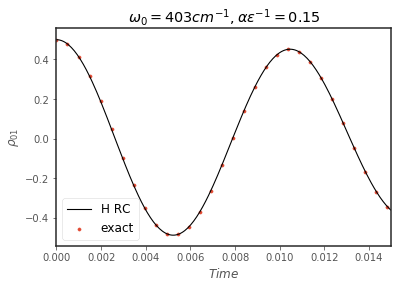

T_ph=300.0
w_RC=403.275 | TLS splitting = 16131.0 | RC-res. coupling=0.03 | TLS-RC coupling=1598.31 | Gamma_RC=80.66 | alpha_ph=4032.75 | N=15 |
eps: 16131.0, alpha: 4032.75, w0: 403.275, Gamma: 80.655, beta: 0.00479616306954
Exact solution 44.444 percent finished
Exact solution 88.889 percent finished
Exact solution took 322.25198102 to calculate.


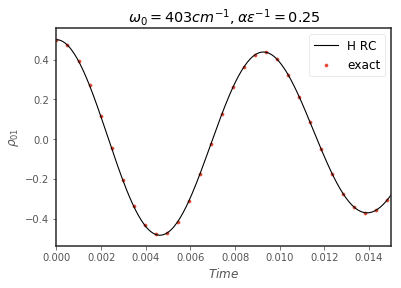

T_ph=300.0
w_RC=403.275 | TLS splitting = 16131.0 | RC-res. coupling=0.03 | TLS-RC coupling=2260.35 | Gamma_RC=80.66 | alpha_ph=8065.50 | N=15 |
eps: 16131.0, alpha: 8065.5, w0: 403.275, Gamma: 80.655, beta: 0.00479616306954
Exact solution 44.444 percent finished
Exact solution 88.889 percent finished
Exact solution took 347.407449007 to calculate.


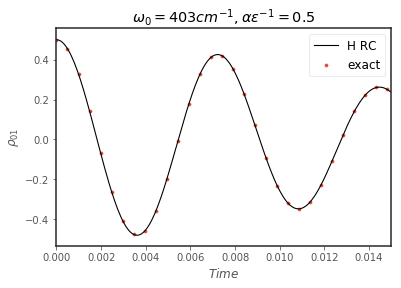

In [7]:
# UD 300K
data_list = []
Gamma = 10e-3*ev_to_inv_cm
w0 = 50e-3*ev_to_inv_cm
N = 15 

for alpha_prop in alpha_over_epsilon:
    data = exact_comparison(alpha_prop=alpha_prop, eps=eps, N=N, Gamma=Gamma, w0=w0,
                            T_ph=300., tf=0.007*2*pi, tN=90, nTimeSteps=15000)
    data_list.append(data)
    title = r"$\omega_0 = "+str(int(w0))+r"cm^{-1}, \alpha\epsilon^{-1} = $"+str(alpha_prop)
    plot_one_exact(data, xlim=0.015, title=title)

#save_obj(data_list, "exact_dynamics_data_UD_300")

In [8]:
plt.style.use('ggplot')
plt.rcParams['text.color'] = 'k'
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['legend.fontsize'] = 16.5
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

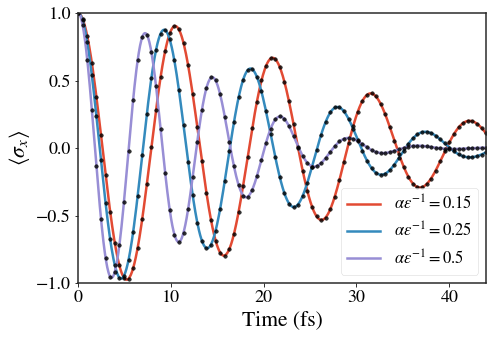

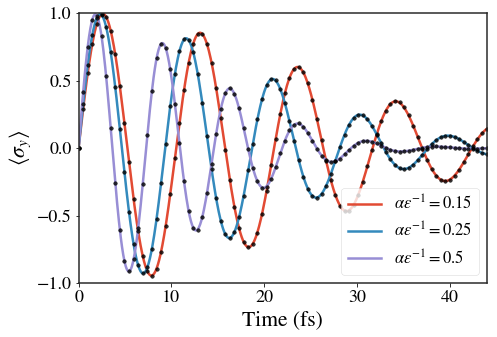

In [12]:
tx_exact = data_list[0]['timelist_exact']*1000*inv_ps_to_inv_cm
tx =  data_list[1]['timelist']*1000*inv_ps_to_inv_cm
plt.figure(figsize=(7,5))

plt.plot(tx, 2*data_list[0]['data_cc'], label=r'$\alpha\epsilon^{-1}=0.15$', zorder=1,  linewidth=2.5)
plt.scatter(tx_exact, 2*data_list[0]['data_exact'], s=13, c='k', alpha=0.8, zorder=2)
plt.plot(tx, 2*data_list[1]['data_cc'], label=r'$\alpha\epsilon^{-1}=0.25$', zorder=1,  linewidth=2.5)
plt.scatter(tx_exact, 2*data_list[1]['data_exact'], s=13, c='k', alpha=0.8, zorder=2)
plt.plot(tx, 2*data_list[2]['data_cc'], label=r'$\alpha\epsilon^{-1}=0.5$', zorder=1,  linewidth=2.5)
plt.scatter(tx_exact, 2*data_list[2]['data_exact'], s=13, c='k', alpha=0.8, zorder=2)
plt.ylabel(r"$\langle \sigma_x \rangle$")
plt.ylim(-1, 1)
plt.xlim(0, 44.)
plt.xlabel("Time (fs)")
plt.legend(loc='lower right')
plt.subplots_adjust(left=0.14, bottom=0.2, right=0.95, top=0.95, wspace=0.25, hspace=0.08)
plt.savefig("exact_comparison_real.pdf")

tx_exact = data_list[0]['timelist_exact']*1000*inv_ps_to_inv_cm
tx =  data_list[1]['timelist']*1000*inv_ps_to_inv_cm
plt.figure(figsize=(7,5))

plt.plot(tx, 2*data_list[0]['data_cc'].imag, label=r'$\alpha\epsilon^{-1}=0.15$', zorder=1,  linewidth=2.5)
plt.scatter(tx_exact, -2*data_list[0]['data_exact'].imag, s=13, c='k', alpha=0.8, zorder=2)
plt.plot(tx, 2*data_list[1]['data_cc'].imag, label=r'$\alpha\epsilon^{-1}=0.25$', zorder=1,  linewidth=2.5)
plt.scatter(tx_exact, -2*data_list[1]['data_exact'].imag, s=13, c='k', alpha=0.8, zorder=2)
plt.plot(tx, 2*data_list[2]['data_cc'].imag, label=r'$\alpha\epsilon^{-1}=0.5$', zorder=1,  linewidth=2.5)
plt.scatter(tx_exact, -2*data_list[2]['data_exact'].imag, s=13, c='k', alpha=0.8, zorder=2)
plt.ylim(-1, 1)
plt.xlim(0, 44.)
plt.ylabel(r"Im$\{\rho_{01}\}$")
plt.ylabel(r"$\langle \sigma_y \rangle $")
plt.xlabel("Time (fs)")
plt.legend(loc='lower right')
plt.subplots_adjust(left=0.14, bottom=0.2, right=0.95, top=0.95, wspace=0.25, hspace=0.08)
plt.savefig("exact_comparison_imag.pdf")

In [97]:
data_list[1]['data_exact']

array([ 1.00000000e+00+0.00000000e+00j,  8.95807743e-01-4.40607178e-01j,
        6.06294310e-01-7.86698580e-01j,  1.95257197e-01-9.65259479e-01j,
       -2.47665123e-01-9.41114592e-01j, -6.27691568e-01-7.24221458e-01j,
       -8.66359518e-01-3.66343001e-01j, -9.18622596e-01+5.18513696e-02j,
       -7.81665020e-01+4.39899137e-01j, -4.93664139e-01+7.18121418e-01j,
       -1.23240596e-01+8.34752600e-01j,  2.47452612e-01+7.75783727e-01j,
        5.41683086e-01+5.65639996e-01j,  7.04591998e-01+2.59125533e-01j,
        7.13508639e-01-7.28789797e-02j,  5.80219181e-01-3.60179772e-01j,
        3.45340543e-01-5.48431689e-01j,  6.67980367e-02-6.09368806e-01j,
       -1.94395951e-01-5.44241629e-01j, -3.87552158e-01-3.80375756e-01j,
       -4.81955812e-01-1.62377031e-01j, -4.71011959e-01+5.94199993e-02j,
       -3.70618276e-01+2.40333082e-01j, -2.12858645e-01+3.50017976e-01j,
       -3.70432128e-02+3.76880692e-01j,  1.19551014e-01+3.27827644e-01j,
        2.29148958e-01+2.24080344e-01j,  2.77777437

In [ ]:
# UD 77K
data_list = []
Gamma = 80.
for N, w0 in zip(N_values, w0_values):
    for alpha_prop in alpha_over_epsilon:
        data = exact_comparison(alpha_prop=alpha_prop, eps=eps, N=N, Gamma=Gamma, w0=w0,
                                T_ph=77., tf=0.025, tN=1000, nTimeSteps=5000)
        data_list.append(data)
        title = r"$\omega_0 = "+str(int(w0))+r"cm^{-1}, \alpha\epsilon^{-1} = $"+str(alpha_prop)
        plot_one_exact(data, xlim=0.025, title=title)

save_obj(data_list, "exact_dynamics_data_UD_77")

T_ph=300.0
w_RC=1000.0 | TLS splitting = 8065.0 | RC-res. coupling=0.48 | TLS-RC coupling=1779.64 | Gamma_RC=3000.00 | alpha_ph=2016.25 | N=15 |
eps: 8065.0, alpha: 2016.25, w0: 1000.0, Gamma: 3000.0, beta: 0.004796163069544365
Exact solution 4.000 percent finished
Exact solution 8.000 percent finished
Exact solution 12.000 percent finished
Exact solution 16.000 percent finished
Exact solution 20.000 percent finished
Exact solution 24.000 percent finished
Exact solution 28.000 percent finished
Exact solution 32.000 percent finished
Exact solution 36.000 percent finished
Exact solution 40.000 percent finished
Exact solution 44.000 percent finished
Exact solution 48.000 percent finished
Exact solution 52.000 percent finished
Exact solution 56.000 percent finished
Exact solution 60.000 percent finished
Exact solution 64.000 percent finished
Exact solution 68.000 percent finished
Exact solution 72.000 percent finished
Exact solution 76.000 percent finished
Exact solution 80.000 percent fin

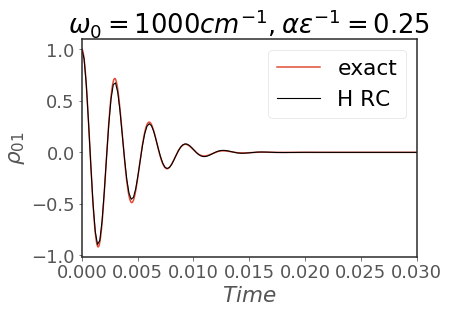

T_ph=300.0
w_RC=1000.0 | TLS splitting = 8065.0 | RC-res. coupling=0.48 | TLS-RC coupling=2516.79 | Gamma_RC=3000.00 | alpha_ph=4032.50 | N=15 |
eps: 8065.0, alpha: 4032.5, w0: 1000.0, Gamma: 3000.0, beta: 0.004796163069544365
Exact solution 4.000 percent finished
Exact solution 8.000 percent finished
Exact solution 12.000 percent finished
Exact solution 16.000 percent finished
Exact solution 20.000 percent finished
Exact solution 24.000 percent finished
Exact solution 28.000 percent finished
Exact solution 32.000 percent finished
Exact solution 36.000 percent finished
Exact solution 40.000 percent finished
Exact solution 44.000 percent finished
Exact solution 48.000 percent finished
Exact solution 52.000 percent finished
Exact solution 56.000 percent finished
Exact solution 60.000 percent finished
Exact solution 64.000 percent finished
Exact solution 68.000 percent finished
Exact solution 72.000 percent finished
Exact solution 76.000 percent finished
Exact solution 80.000 percent fini

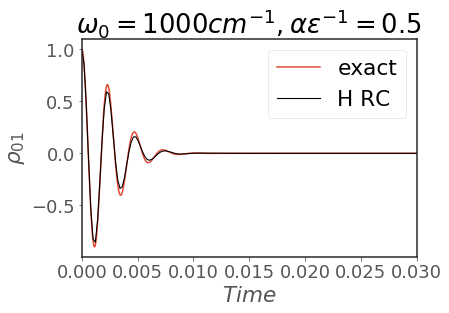

In [8]:
# OD 300K
data_list = []
N_values = [15, 15, 15]
Gamma = 3000.
for N, w0 in zip(N_values, [1000.]):
    for alpha_prop in alpha_over_epsilon:
        data = exact_comparison(alpha_prop=alpha_prop, eps=eps, N=N, Gamma=Gamma, w0=w0,
                                T_ph=300., tf=0.03, tN=1000, nTimeSteps=5000)
        data_list.append(data)
        title = r"$\omega_0 = "+str(int(w0))+r"cm^{-1}, \alpha\epsilon^{-1} = $"+str(alpha_prop)
        plot_one_exact(data, xlim=0.03, title=title)

save_obj(data_list, "exact_dynamics_data_OD_300")

In [9]:
# OD 77K
data_list = []
#N_values = [8, 9, 10]
Gamma = 3000.
for N, w0 in zip(N_values, [1000.]):
    for alpha_prop in alpha_over_epsilon:
        data = exact_comparison(alpha_prop=alpha_prop, eps=eps, N=N, Gamma=Gamma, w0=w0,
                                T_ph=77., tf=0.05, tN=1000, nTimeSteps=5000)
        data_list.append(data)
        title = r"$\omega_0 = "+str(int(w0))+r"cm^{-1}, \alpha\epsilon^{-1} = $"+str(alpha_prop)
        plot_one_exact(data, xlim=0.03, title=title)

save_obj(data_list, "exact_dynamics_data_OD_77")

T_ph=77.0
w_RC=1000.0 | TLS splitting = 8065.0 | RC-res. coupling=0.48 | TLS-RC coupling=1779.64 | Gamma_RC=3000.00 | alpha_ph=2016.25 | N=15 |
eps: 8065.0, alpha: 2016.25, w0: 1000.0, Gamma: 3000.0, beta: 0.01868634962160142
Exact solution 4.000 percent finished
Exact solution 8.000 percent finished
Exact solution 12.000 percent finished
Exact solution 16.000 percent finished
Exact solution 20.000 percent finished
Exact solution 24.000 percent finished
Exact solution 28.000 percent finished
Exact solution 32.000 percent finished
Exact solution 36.000 percent finished
Exact solution 40.000 percent finished
Exact solution 44.000 percent finished
Exact solution 48.000 percent finished
Exact solution 52.000 percent finished
Exact solution 56.000 percent finished
Exact solution 60.000 percent finished
Exact solution 64.000 percent finished
Exact solution 68.000 percent finished
Exact solution 72.000 percent finished


KeyboardInterrupt: 

In [49]:
(1000**2)/300

3333.3333333333335

In [50]:
N_values = [4, 5, 6, 7, 8, 9, 10, 11]
xlim = np.linspace(0.3, 0.05, len(alpha_over_epsilon))
data_list = []
for i, alpha_prop in enumerate(alpha_over_epsilon):
    data = exact_comparison(alpha_prop=alpha_prop, eps=8065., N=N_values[i], Gamma=3000., w0 =  1000,
                            T_ph=300., tf=0.30, tN=1000, nTimeSteps=5000)
    plot_one_exact(data, xlim=xlim[i])
    data_list.append(data)

save_obj(data_list, "exact_dynamics_data_OD_300")

T_ph=300.0
w_RC=1000 | TLS splitting = 8065.0 | RC-res. coupling=0.48 | TLS-RC coupling=317.51 | Gamma_RC=3000.00 | alpha_ph=64.18 | N=4 |
eps: 8065.0, alpha: 64.1792308018068, w0: 1000, Gamma: 3000.0, beta: 0.004796163069544365
Exact solution 4.000 percent finished
Exact solution 8.000 percent finished
Exact solution 12.000 percent finished
Exact solution 16.000 percent finished


KeyboardInterrupt: 

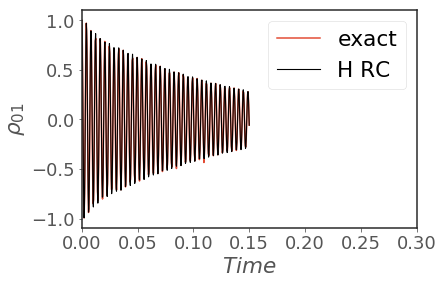

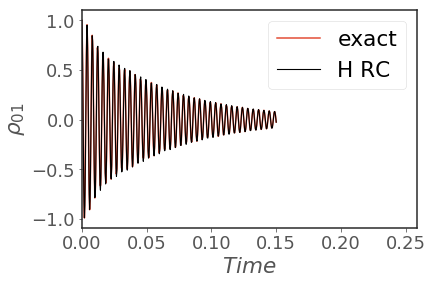

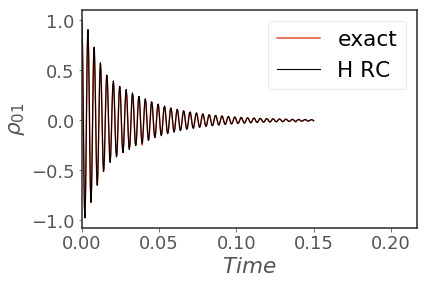

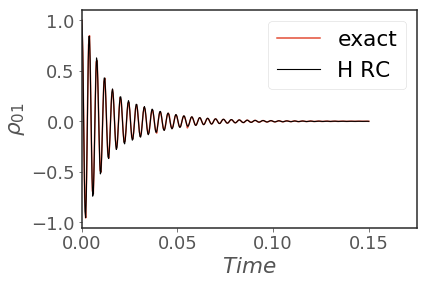

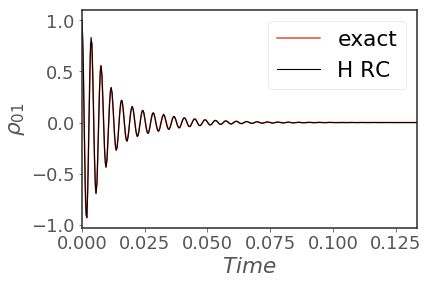

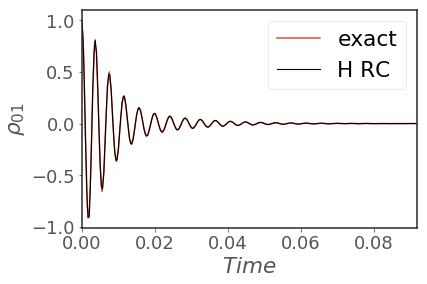

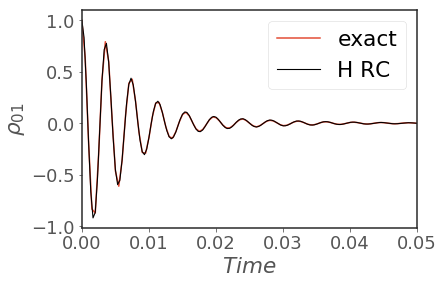

In [40]:
data_list_OD = load_obj("exact_dynamics_data_OD")
xlim = np.linspace(0.3, 0.05, 7)
for xl, alpha in zip(xlim, data_list_OD):
    plot_one_exact(alpha, xlim=xl)

In [ ]:
N_values = [4, 5, 6, 7, 8, 9, 10, 11]
data_list = []
for N, alpha_prop in zip(N_values, alpha_over_epsilon):
    data = exact_comparison(alpha_prop=alpha_prop, eps=8065., N=N, Gamma=2000., w0 =  1000,
                            T_ph=300., tf=0.30, tN=600, nTimeSteps=5000)
    data_list.append(data)

save_obj(data_list, "exact_dynamics_data_OD_77")